#### Import libraries and packages

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns

#### Set connection with postgres database

In [2]:
host = 'postgresfib.fib.upc.edu'
dbname = 'ADSDBjordi.cluet'
user = 'jordi.cluet'
pwd = 'DB151199'
port = 6433
sslmode = 'require'

conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, user, pwd))
cursor = conn.cursor()

#### Select whole table as dataframe

In [3]:
sql = "SELECT * from formatted_zone.zenodo_fotocasa_2020_21_12_06;"
df = pd.read_sql_query(sql, conn)
df.head()

,id,address,bathrooms,building_subtype,building_type,conservation_state,extraction_date,discount,floor_elevator,is_new_construction,link,price,real_estate,real_estate_id,rooms,sq_meters,neighbourhood,neighbourhood_mean_price
0,0,"Carrer Roger de Lluria, Dreta de l'Eixample",3,Flat,Flat,0,2020-10-28,0,1,False,/es/alquiler/vivienda/barcelona-capital/calefa...,5000.0,SOMOS REAL ESTATE SERVICES,9202765680731,3,208.0,la dreta de l'eixample,1307.616842
1,1,Sant Antoni,1,Flat,Flat,1,2020-10-28,0,1,False,/es/alquiler/vivienda/barcelona-capital/aire-a...,1250.0,TECNOCASA RIERA ALTA MAR,9202751363773,3,93.0,sant antoni,994.909158
2,2,"Carrer Valencia, La Nova Esquerra de l'Eixample",2,Flat,Flat,0,2020-10-28,0,1,False,/es/alquiler/vivienda/barcelona-capital/calefa...,1600.0,SOMOS REAL ESTATE SERVICES,9202765680731,4,129.0,la nova esquerra de l'eixample,1053.832393
3,3,"Carrer Muntaner, Sant Gervasi- Galvany",2,Flat,Flat,0,2020-10-28,0,1,False,/es/alquiler/vivienda/barcelona-capital/aire-a...,3200.0,SOMOS REAL ESTATE SERVICES,9202765680731,2,133.0,sant gervasi - galvany,1397.273005
4,4,"Rambla del Raval, El Raval",1,Flat,Flat,2,2020-10-28,0,1,False,/es/alquiler/vivienda/barcelona-capital/ascens...,1000.0,ESTUDI JOAN MIRO.SL.,9202762439813,3,67.0,el raval,850.112343


#### Remove unuseful columns

In [4]:
df = df.drop(['extraction_date', 'link'], axis = 1)  # non-useful columns

#### Check data types

In [5]:
df.dtypes

id                            int64
address                      object
bathrooms                     int64
building_subtype             object
building_type                object
conservation_state            int64
discount                      int64
floor_elevator                int64
is_new_construction            bool
price                       float64
real_estate                  object
real_estate_id               object
rooms                         int64
sq_meters                   float64
neighbourhood                object
neighbourhood_mean_price    float64
dtype: object

#### Correct some data types

In [6]:
df['id'] = df['id'].astype("object")
df['address'] = df['address'].astype("string")
df['building_subtype'] = df['building_subtype'].astype("category")
df['building_type'] = df['building_type'].astype("category")
df['conservation_state'] = df['conservation_state'].astype("category")
df['floor_elevator'] = df['floor_elevator'].astype("bool")
df['real_estate'] = df['real_estate'].astype("category")
df['real_estate_id'] = df['real_estate_id'].astype("object")
df['neighbourhood'] = df['neighbourhood'].astype("category")

In [7]:
df.dtypes

id                            object
address                       string
bathrooms                      int64
building_subtype            category
building_type               category
conservation_state          category
discount                       int64
floor_elevator                  bool
is_new_construction             bool
price                        float64
real_estate                 category
real_estate_id                object
rooms                          int64
sq_meters                    float64
neighbourhood               category
neighbourhood_mean_price     float64
dtype: object

### Remove duplicates

There is an important amount of duplicates (more than a thousand). We remove them.

In [8]:
print("Initial rows:\t", len(df))
print("Duplicated rows: ", sum(df.iloc[:, 1:].duplicated()))
df = df[-df.iloc[:, 1:].duplicated()]
df = df.reset_index(drop=True)
print("Final rows:\t ", len(df))

Initial rows:	 10928
Duplicated rows:  1183
Final rows:	  9745


---

### Categorical variables

#### Summary of categorical variables

In [9]:
df.describe(include = ['category', 'bool'])

,building_subtype,building_type,conservation_state,floor_elevator,is_new_construction,real_estate,neighbourhood
count,9745,9745,9745,9745,9745,9745,9745
unique,10,1,6,2,2,1116,67
top,Flat,Flat,0,True,False,ENGEL & VOELKERS,la dreta de l'eixample
freq,7770,9745,5457,6930,9655,800,829


#### Check levels of categorical variables

##### building_type
We remove it since it only has 1 unique value.

In [10]:
df = df.drop(['building_type'], axis = 1)

##### building_subtype
There are 10 different [sub]types of building. Most of them are flats.

In [11]:
df['building_subtype'].value_counts()

Flat                     7770
Apartment                1095
Attic                     389
Duplex                    142
Loft                      134
Study                     101
House_Chalet               49
GroundFloorWithGarden      41
SemidetachedHouse          14
SemiDetached               10
Name: building_subtype, dtype: int64

<AxesSubplot:>

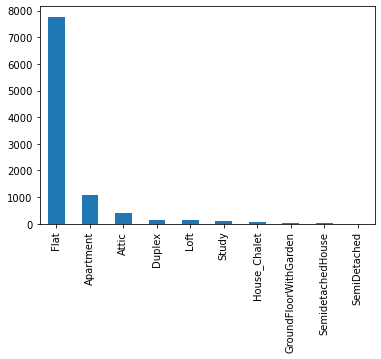

In [12]:
df['building_subtype'].value_counts().plot(kind='bar')

##### conservation_state
There are 6 different conservation states in Fotocasa classification. We properly re-encode them as they are displayed on their website. Most of the homes are new constructions, surprisingly.

In [13]:
df['conservation_state'].value_counts()

0    5457
1    1642
2    1393
3    1209
8      28
4      16
Name: conservation_state, dtype: int64

In [14]:
df['conservation_state'] = df['conservation_state'].replace({
    0: 'New construction', 
    1: 'Nearly new', 
    2: 'Very good', 
    3: 'Good', 
    4: 'To renovate', 
    8: 'Renovated'
  })
df['conservation_state'].value_counts()

New construction    5457
Nearly new          1642
Very good           1393
Good                1209
Renovated             28
To renovate           16
Name: conservation_state, dtype: int64

<AxesSubplot:>

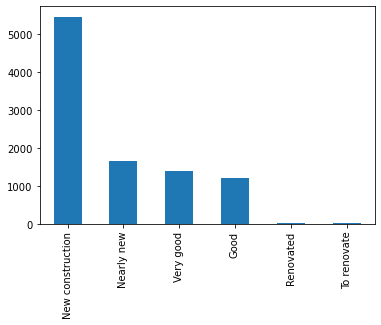

In [15]:
df['conservation_state'].value_counts().plot(kind='bar')

##### floor_elevator
Most of the homes have an elevator.

In [16]:
df['floor_elevator'].value_counts()

True     6930
False    2815
Name: floor_elevator, dtype: int64

<AxesSubplot:>

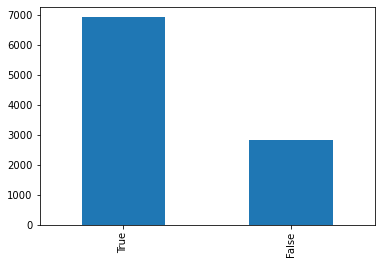

In [17]:
df['floor_elevator'].value_counts()[:10].plot(kind='bar')

##### is_new_construction
Almost no house is newly constructed according to this variable. This contradicts what the variable 'conservation_state' indicates.

In [18]:
df['is_new_construction'].value_counts()

False    9655
True       90
Name: is_new_construction, dtype: int64

<AxesSubplot:>

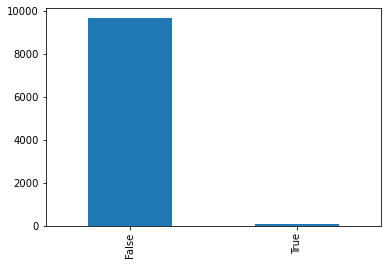

In [19]:
df['is_new_construction'].value_counts()[:10].plot(kind='bar')

In [20]:
df[df['is_new_construction'] == True]['conservation_state'].value_counts()

New construction    90
Name: conservation_state, dtype: int64

In [21]:
df[df['conservation_state'] == 'New construction']['is_new_construction'].value_counts()

False    5367
True       90
Name: is_new_construction, dtype: int64

We remove the variable since it seems wrongly assigned and the same information is given in conservation_state variable.

In [22]:
df = df.drop(['is_new_construction'], axis = 1)

##### real_estate
There are 1116 different real_estate agencies. Some of them concentrate most of the homes. There are some missing ones with respect to real_estate_id (we deal with this issue later).

In [23]:
len(df['real_estate'].unique())

1116

In [24]:
len(df['real_estate_id'].unique())

1317

In [25]:
df['real_estate'].value_counts()[:10]

ENGEL & VOELKERS                         800
APROPERTIES REAL ESTATE Nº Aicat 6388    498
SH BARCELONA                             457
Homelike                                 305
AREA CASA                                297
NaN                                      172
ALL4FLAT                                 168
PUNTO HABITAT                            160
DOMINGUEZ                                145
CASAMONA                                 123
Name: real_estate, dtype: int64

In [26]:
sum(df['real_estate'] == 'NaN')

172

<AxesSubplot:>

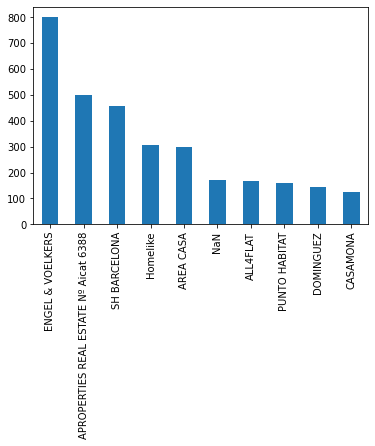

In [27]:
df['real_estate'].value_counts()[:10].plot(kind='bar')

##### neighbourhood
The database contains homes in 66 out of the 73  neighboourhoods of Barcelona (2 rows do not have a neighbourhood set). This will be treated later.

In [28]:
len(df['neighbourhood'].unique().tolist())

67

In [29]:
sum(df['neighbourhood'] == 'NaN')

2

<AxesSubplot:>

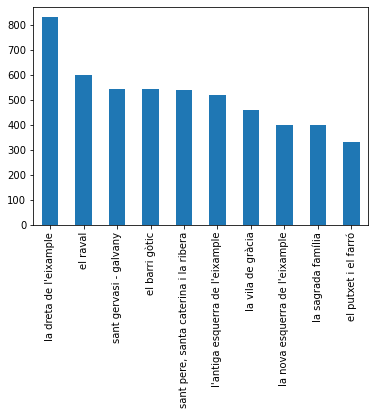

In [30]:
df['neighbourhood'].value_counts()[:10].plot(kind='bar')

---

### Numerical variables

#### Summary of numerical variables

In [31]:
df.describe()

,bathrooms,discount,price,rooms,sq_meters,neighbourhood_mean_price
count,9745.000000,9745.000000,9741.000000,9745.000000,9745.000000,9743.000000
mean,1.503027,67.798358,1433.827738,2.402668,86.960082,1058.224572
std,0.786545,232.352200,1155.961207,1.188768,62.566014,211.728578
min,0.000000,0.000000,380.000000,0.000000,0.000000,419.427143
25%,1.000000,0.000000,900.000000,2.000000,58.000000,882.010785
50%,1.000000,0.000000,1130.000000,2.000000,75.000000,1004.723491
75%,2.000000,87.000000,1500.000000,3.000000,98.000000,1162.321630
max,11.000000,7627.000000,29000.000000,22.000000,1450.000000,1860.558980


#### Define function to get outliers

In [32]:
def get_outliers(var, factor):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df[var] < Q1-factor*IQR) | (df[var] > Q3+factor*IQR)
    return outliers

#### Analysis, missing values and outliers of numerical variables

#### bathrooms
Homes have from 0 to 11 bathrooms. Most of them have 1 to 3 bathrooms, as would be expected.

In [33]:
df['bathrooms'].value_counts()

1     5579
2     3314
3      478
0      155
4      146
5       45
6       15
7        5
8        4
9        2
11       2
Name: bathrooms, dtype: int64

array([[<AxesSubplot:title={'center':'bathrooms'}>]], dtype=object)

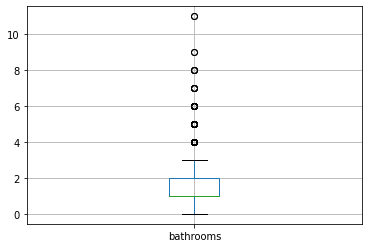

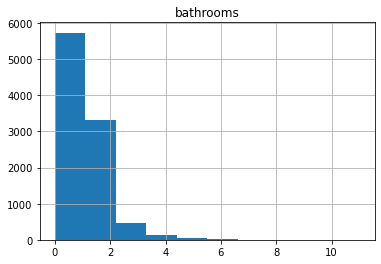

In [34]:
df.boxplot('bathrooms')
df.hist('bathrooms')

In [35]:
outliers = get_outliers('bathrooms', 3)
sum(outliers)

28

It seems that these outliers are real huge houses in rich neighbourhoods such as Pedralbes. We remove them since they may produce errors in the modelling part.

In [36]:
df[outliers].head()

,id,address,bathrooms,building_subtype,conservation_state,discount,floor_elevator,price,real_estate,real_estate_id,rooms,sq_meters,neighbourhood,neighbourhood_mean_price
367,368,Pedralbes,9,House_Chalet,Good,0,False,14000.0,APROPERTIES REAL ESTATE Nº Aicat 6388,9202753825457,8,1000.0,pedralbes,1860.558980
651,657,"Avinguda Tibidabo, Sant Gervasi i la Bonanova",8,House_Chalet,New construction,0,False,15000.0,WITHFOR,9202761636569,11,773.0,sant gervasi - la bonanova,1304.341823
978,987,Vallvidrera - Tibidabo - Les Planes,7,SemiDetached,Nearly new,0,False,8400.0,ENGEL & VOELKERS,9202758116439,5,724.0,"vallvidrera, el tibidabo i les planes",1205.654935
1306,1321,Sant Gervasi- Galvany,6,Duplex,Nearly new,400,True,9500.0,ENGEL & VOELKERS,9202758116439,5,375.0,sant gervasi - galvany,1397.273005
1531,1547,Pedralbes,6,SemiDetached,Nearly new,0,False,18000.0,ENGEL & VOELKERS,9202758116439,6,1075.0,pedralbes,1860.558980


In [37]:
df = df[-outliers]

array([[<AxesSubplot:title={'center':'bathrooms'}>]], dtype=object)

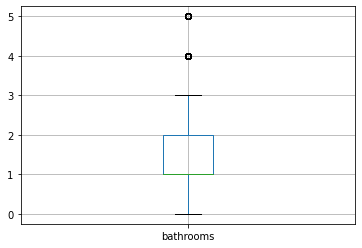

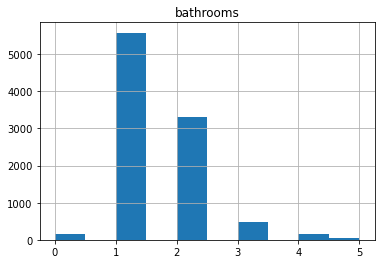

In [38]:
df.boxplot('bathrooms')
df.hist('bathrooms')

#### discount
There are huge discounts which do not seem realistic.

array([[<AxesSubplot:title={'center':'discount'}>]], dtype=object)

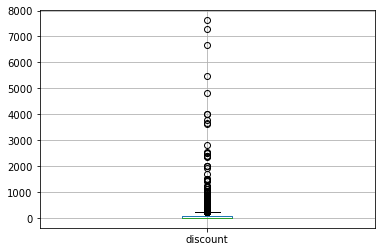

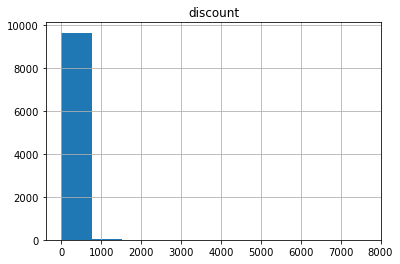

In [39]:
df.boxplot('discount')
df.hist('discount')

In [40]:
outliers = get_outliers('discount', 5)
sum(outliers)

133

In [41]:
df = df[-outliers]

array([[<AxesSubplot:title={'center':'discount'}>]], dtype=object)

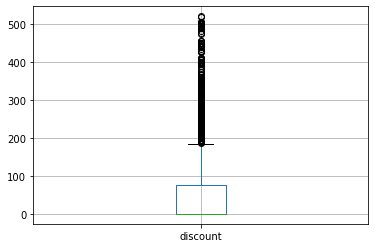

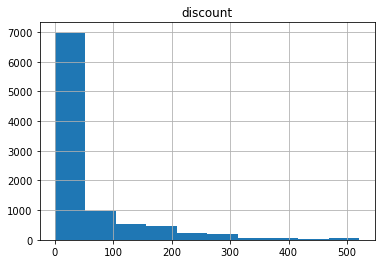

In [42]:
df.boxplot('discount')
df.hist('discount')

#### price
This is our target variable. There are some clear outliers that should be removed.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

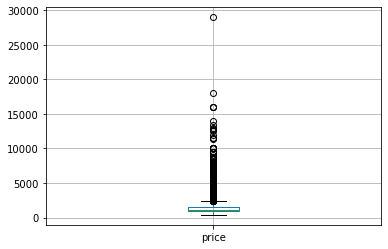

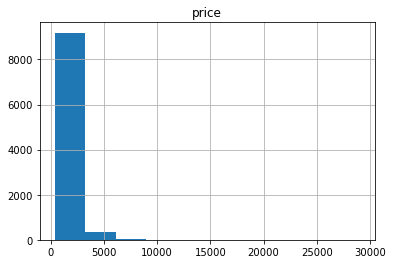

In [43]:
df.boxplot('price')
df.hist('price')

In [44]:
extreme_outliers = df['price'] > 15000
sum(extreme_outliers)

5

In [45]:
df = df[-extreme_outliers]

In [46]:
outliers = get_outliers('price', 5)
sum(outliers)

138

In [47]:
df = df[-outliers]

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

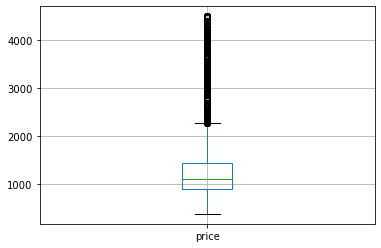

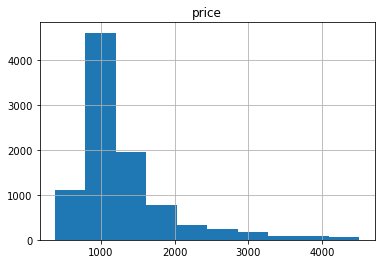

In [48]:
df.boxplot('price')
df.hist('price')

#### rooms

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

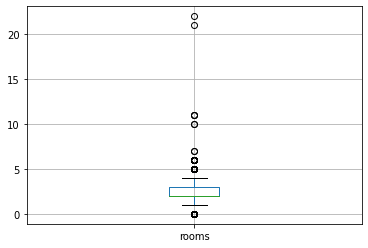

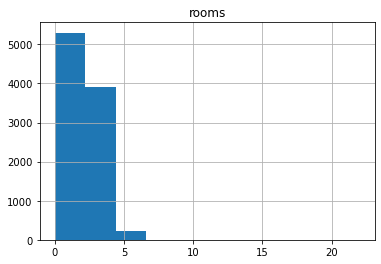

In [49]:
df.boxplot('rooms')
df.hist('rooms')

In [50]:
outliers = get_outliers('rooms', 3)
sum(outliers)

9

In [51]:
df = df[-outliers]

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

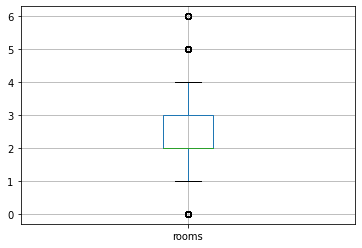

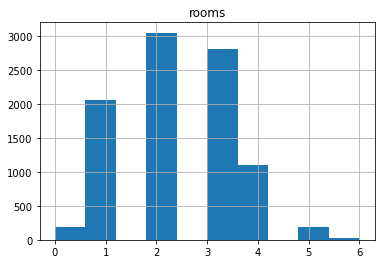

In [52]:
df.boxplot('rooms')
df.hist('rooms')

#### sq_meters
There are huge houses that should be considered outliers.

array([[<AxesSubplot:title={'center':'sq_meters'}>]], dtype=object)

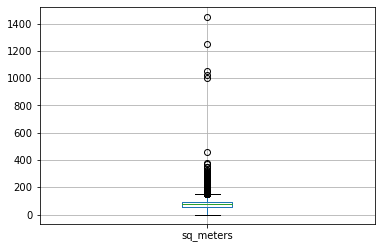

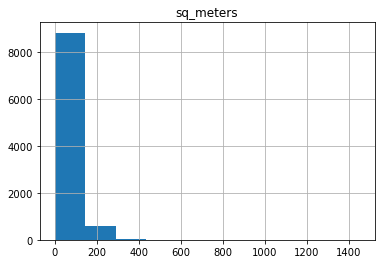

In [53]:
df.boxplot('sq_meters')
df.hist('sq_meters')

In [54]:
outliers = get_outliers('sq_meters', 5)
sum(outliers)

23

In [55]:
df = df[-outliers]

There are also homes that are too little acoording to the variable

In [56]:
df = df.reset_index(drop=True)
little = df['sq_meters'] <= 15
print(sum(little))
df[little].head()

27


,id,address,bathrooms,building_subtype,conservation_state,discount,floor_elevator,price,real_estate,real_estate_id,rooms,sq_meters,neighbourhood,neighbourhood_mean_price
37,38,"Castillejos, Sagrada Família",2,Flat,New construction,0,True,1015.0,ARNAL Servicios Inmobiliarios,9202750542526,3,0.0,la sagrada família,960.212676
530,559,"Carrer de Sant Germà, 20, La Font de la Guatlla",1,Study,New construction,0,False,625.0,JOAQUIN,9202761160881,1,15.0,la font de la guatlla,865.921000
714,750,Sagrada Família,1,Flat,Very good,0,True,975.0,Assumpta Sant,9202765643201,4,0.0,la sagrada família,960.212676
1092,1149,"Carrer del Taulat, El Poblenou",1,Flat,Good,0,True,990.0,GAND HOUSE,9202751271441,3,0.0,el poblenou,1004.723491
1162,1220,"Raval, El Raval",1,Apartment,Very good,0,True,625.0,MARCEL PELLICER,9202751359888,0,0.0,el raval,850.112343


They seem errors, so we set them to NA to impute them later.

In [57]:
df.loc[little, 'sq_meters'] = np.nan

array([[<AxesSubplot:title={'center':'sq_meters'}>]], dtype=object)

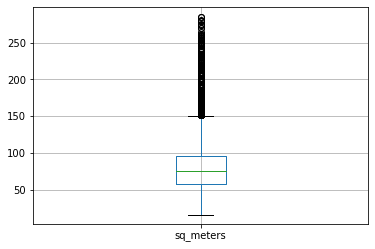

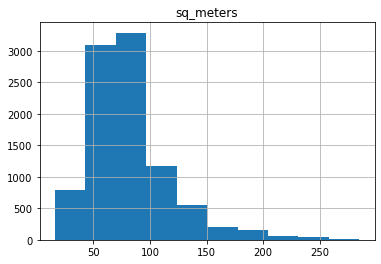

In [58]:
df.boxplot('sq_meters')
df.hist('sq_meters')

#### neighbourhood_mean_price
There are 66 unique values (one for each neighbourhood), so it seems correct. Outliers belong to rich neighbourhoods (such as Pedralbes) or poorer ones (such as Ciutat Meridiana). We observe a couple of missing values which will be treated later.

In [59]:
aux = df.iloc[:,-2:].drop_duplicates().dropna()
aux = aux.sort_values(by=['neighbourhood_mean_price'], ascending=False)
aux = aux.reset_index(drop=True)
aux

,neighbourhood,neighbourhood_mean_price
0,pedralbes,1860.558980
1,les tres torres,1657.026446
2,sant gervasi - galvany,1397.273005
3,sarrià,1375.103236
4,diagonal mar i el front marítim del poblenou,1372.381900
...,...,...
61,la trinitat nova,606.733103
62,la trinitat vella,602.875506
63,vallbona,581.969091
64,ciutat meridiana,562.082302


---

### Missing values

In [60]:
df = df.reset_index(drop=True)

##### Count missing values

In [61]:
df = df.replace('NaN', np.nan, regex=True)
df.isna().sum()

id                            0
address                       0
bathrooms                     0
building_subtype              0
conservation_state            0
discount                      0
floor_elevator                0
price                         4
real_estate                 171
real_estate_id                0
rooms                         0
sq_meters                    27
neighbourhood                 2
neighbourhood_mean_price      2
dtype: int64

##### Manually correct 2 missings in neighbourhood and neighbourhood_mean_price

In [62]:
df[df['neighbourhood'].isna()]

,id,address,bathrooms,building_subtype,conservation_state,discount,floor_elevator,price,real_estate,real_estate_id,rooms,sq_meters,neighbourhood,neighbourhood_mean_price
927,968,"Avenida Meridiana, 256, Sant Andreu",1,Flat,New construction,0,True,1443.0,NUÑEZ I NAVARRO,9202756861499,2,69.0,NaN,NaN
8819,9380,Zona Franca - Port,1,Study,Very good,0,True,550.0,LORDA ADMINSTRACION FINCAS,9202753020505,1,23.0,NaN,NaN


In [63]:
df.loc[df['id'] == 968, 'neighbourhood'] = 'sant andreu'
df.loc[df['id'] == 9380, 'neighbourhood'] = 'la marina de port'

In [64]:
df.loc[df['id'] == 968, 'neighbourhood_mean_price'] = df[df['neighbourhood'] == 'sant andreu']['neighbourhood_mean_price'].mean()
df.loc[df['id'] == 9380, 'neighbourhood_mean_price'] = df[df['neighbourhood'] == 'la marina de port']['neighbourhood_mean_price'].mean()

##### Remove 4 rows with missing price (since it is the target)

In [65]:
df = df[-df['price'].isna()]

##### Impute missings in sq_meters using KNN method

In [66]:
df = df.reset_index(drop=True)

In [67]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")

In [68]:
newData = df.select_dtypes('number').iloc[:,1:]
newData = pd.DataFrame(imputer.fit_transform(newData), columns=newData.columns)

In [69]:
df['sq_meters'] = newData['sq_meters'].copy()
df['sq_meters'].isna().any()

False

##### Check missings in real_estate

We observe that there are no missing real_estate_ids but there are some missing real_estate names.
Each real_estate_id corresponds to a single real_estate name (so it seems that there are no typos).

Therefore, from now on, we will use real_estate names as a complementary information (may be useful in plots, for example) but in the modelling phase only real_estate_id will be indicated for use.

In [70]:
l = df.groupby('real_estate_id')['real_estate'].nunique()
print(min(l), max(l))

0 1


So we are finally left with missing values only in real_estate, as explained above.

In [71]:
df.isna().any()

id                          False
address                     False
bathrooms                   False
building_subtype            False
conservation_state          False
discount                    False
floor_elevator              False
price                       False
real_estate                  True
real_estate_id              False
rooms                       False
sq_meters                   False
neighbourhood               False
neighbourhood_mean_price    False
dtype: bool